In [1]:
# Factor Analysis를 통해 대략적인 경향성을 파악
# 단 roc_auc_score가 높지 않으므로 이후 다른 파일에서 각 Feature들을 세부적으로 뜯어서 분석 예정

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.formula.api as smfa

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score
from sklearn.pipeline import make_pipeline
from factor_analyzer import FactorAnalyzer

In [4]:
from data.utils import add_experience, feature_classification, astype_category

In [5]:
# DataFrame 초기 세팅
hr_df = pd.read_csv(Path.cwd() / 'data' / 'HR-Employee-Attrition.csv')
hr_df = (hr_df
         .pipe(add_experience)
         .pipe(feature_classification, return_dataframe=True)
         .pipe(astype_category)
         .set_index('EmployeeNumber')
)
hr_df = (hr_df
         .assign(Attrition=lambda df: df['Attrition'].replace({'Yes':1, 'No':0}))
         .assign(OverTime=lambda df: df['OverTime'].replace({'Yes':1, 'No':0}))
)
hr_df.columns

Index(['MonthlyIncome', 'PercentSalaryHike', 'StockOptionLevel', 'Age',
       'Gender', 'MaritalStatus', 'Education', 'EducationField',
       'DistanceFromHome', 'NumCompaniesWorked', 'TotalWorkingYears',
       'Experienced', 'Department', 'BusinessTravel', 'JobLevel', 'JobRole',
       'JobInvolvement', 'OverTime', 'WorkLifeBalance',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'PerformanceRating',
       'RelationshipSatisfaction', 'Attrition'],
      dtype='object')

In [6]:
# 필요 내용 category 변경 확인
hr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 1 to 2068
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   MonthlyIncome             1470 non-null   int64   
 1   PercentSalaryHike         1470 non-null   int64   
 2   StockOptionLevel          1470 non-null   int64   
 3   Age                       1470 non-null   int64   
 4   Gender                    1470 non-null   category
 5   MaritalStatus             1470 non-null   category
 6   Education                 1470 non-null   category
 7   EducationField            1470 non-null   category
 8   DistanceFromHome          1470 non-null   int64   
 9   NumCompaniesWorked        1470 non-null   int64   
 10  TotalWorkingYears         1470 non-null   int64   
 11  Experienced               1470 non-null   category
 12  Department                1470 non-null   category
 13  BusinessTravel            1470 non-null   catego

In [7]:
# categorical variables에 대한 one-hot encoding
hr_df_onehot = pd.get_dummies(hr_df, columns=['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction',
                                              'Experienced', 'Gender', 'JobRole', 'MaritalStatus'])
hr_df_onehot

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_LaboratoryTechnician,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,5993,11,0,41,1,8,8,2,3,1,...,0,0,0,0,0,1,0,0,0,1
2,5130,23,1,49,8,1,10,2,2,0,...,0,0,0,0,1,0,0,0,1,0
4,2090,15,0,37,2,6,7,1,2,1,...,1,0,0,0,0,0,0,0,0,1
5,2909,11,0,33,3,1,8,1,3,1,...,0,0,0,0,1,0,0,0,1,0
7,3468,12,1,27,2,9,6,1,3,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,2571,17,1,36,23,4,17,2,4,0,...,1,0,0,0,0,0,0,0,1,0
2062,9991,15,1,39,6,4,9,3,2,0,...,0,0,0,0,0,0,0,0,1,0
2064,6142,20,1,27,4,1,6,2,4,1,...,0,0,1,0,0,0,0,0,1,0


In [8]:
X = hr_df_onehot.drop('Attrition', axis=1)
y = hr_df_onehot['Attrition']
X.shape, y.shape

((1470, 57), (1470,))

In [9]:
# Standard Scaler 진행
scaler = StandardScaler().fit(X)
X_sc = scaler.transform(X)

In [10]:
# Factor analysis를 통한 Factor 확인
# Dimensionality Reduction 이후 Variance 설명량을 확인하여 적절한 factor 개수 추출
cumul_var_list = []
for i in range(3, 50):
    fa = FactorAnalyzer(n_factors=i, method='principal', rotation='varimax').fit(X_sc)
    cumul_var_list.append(fa.get_factor_variance()[2][i-1])
np.array(cumul_var_list)

array([0.20296417, 0.24266582, 0.28004285, 0.31683127, 0.35190734,
       0.38484269, 0.41569196, 0.44462029, 0.47193829, 0.49876796,
       0.52393291, 0.54815021, 0.57265866, 0.59530276, 0.61840056,
       0.63951629, 0.66134305, 0.68139693, 0.70133243, 0.72161308,
       0.74141462, 0.76052223, 0.77902019, 0.79741842, 0.81524863,
       0.83227157, 0.84903662, 0.86572735, 0.88210299, 0.89804901,
       0.91380448, 0.9287388 , 0.94105243, 0.95236389, 0.96133638,
       0.96994966, 0.97636377, 0.98124611, 0.98564892, 0.98949389,
       0.99315907, 0.99534437, 0.99708677, 0.99849409, 0.99939804,
       1.        , 1.02356445])

In [11]:
# Variance 설명량이 60%가 넘는 n_factors를 선택하여 Factor Loadings 확인
n_factors = 17
fa = FactorAnalyzer(n_factors=n_factors, method='principal', rotation='varimax').fit(X_sc)
fl_matrix = pd.DataFrame(fa.loadings_, columns=[f'Factor{i:02}' for i in range(1, n_factors + 1)], index=X.columns)
fl_matrix

,Factor01,Factor02,Factor03,Factor04,Factor05,Factor06,Factor07,Factor08,Factor09,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17
MonthlyIncome,0.927595,0.042011,-0.016160,-0.013420,0.010166,0.229455,0.000730,-0.018829,-0.018350,-0.000075,-0.009988,0.013772,0.029502,-0.003529,0.033760,-0.015770,-0.008630
PercentSalaryHike,-0.007293,-0.025800,-0.019383,0.001411,0.002340,-0.019736,-0.007410,0.010602,0.934322,0.008998,0.006201,-0.012117,0.012008,-0.021099,-0.000831,-0.014847,-0.025728
StockOptionLevel,-0.012302,0.006071,-0.014016,0.017658,0.859311,0.013301,0.001299,0.012830,0.004653,0.019535,-0.003428,0.153693,0.011871,-0.005552,-0.000512,0.002685,0.031598
Age,0.625501,-0.030952,-0.004028,0.119448,0.065713,0.132777,0.023459,-0.017041,0.006453,-0.019498,0.157424,-0.054011,0.010028,0.026958,-0.020994,0.185277,0.182229
DistanceFromHome,-0.073124,0.051696,-0.016843,-0.090719,0.073304,0.065241,0.010174,0.050393,0.077197,0.115765,0.007284,-0.065837,0.019745,-0.007408,-0.041797,0.117482,0.168774
NumCompaniesWorked,0.250869,-0.021927,-0.005705,0.771748,-0.000244,-0.190691,0.019537,-0.026635,-0.000036,0.000687,0.046423,0.008423,0.020297,0.008126,-0.031311,0.373770,0.134717
TotalWorkingYears,0.795315,-0.039402,-0.017441,0.017715,0.010597,0.390400,0.021656,-0.014706,-0.001214,0.008263,0.052406,-0.007561,0.019751,0.013629,-0.012701,0.122004,0.105070
JobLevel,0.901083,0.095940,-0.030549,-0.023502,0.018770,0.271477,0.012048,-0.001941,-0.023980,-0.009077,-0.006232,0.017277,0.006065,0.013633,0.062588,0.010534,0.012831
JobInvolvement,-0.024163,-0.022360,0.008848,-0.001893,0.069515,0.019345,-0.023855,-0.046853,-0.046682,0.022710,0.018021,-0.039805,0.092740,-0.011332,-0.123717,0.038942,0.043296
OverTime,0.013351,-0.000314,0.012187,-0.050871,0.028280,-0.029926,0.085546,0.018806,-0.001651,0.040023,0.191436,0.038833,-0.009038,0.206922,-0.087394,0.076091,-0.172872


In [12]:
# 각 Columns가 어떤 Factor에 속하는지, 그 Factor에서의 Factor Loadings는 어떻게 되는지 확인
fl_df = (pd.concat([fl_matrix.idxmax(axis=1), fl_matrix.max(axis=1)], axis=1)
         .rename({0:'Idxmax', 1:'Max'}, axis=1)
         .sort_values(by='Idxmax', ascending=True)
)
fl_df

,Idxmax,Max
MonthlyIncome,Factor01,0.927595
Age,Factor01,0.625501
TotalWorkingYears,Factor01,0.795315
JobLevel,Factor01,0.901083
JobRole_ResearchDirector,Factor01,0.510888
JobRole_Manager,Factor01,0.593684
BusinessTravel_Travel_Rarely,Factor01,0.040209
JobRole_SalesRepresentative,Factor02,0.294770
Department_Sales,Factor02,0.957127
JobRole_SalesExecutive,Factor02,0.841694


In [13]:
# Max Factor Loadings가 0.5 이하인 Features를 택하여 해당 Features를 제거
not_sig_feats_in_fa = (fl_df
                       .query("Max < 0.5")
                       .index
)
not_sig_feats_in_fa = not_sig_feats_in_fa.to_list()
X_remove = X.drop(not_sig_feats_in_fa, axis=1)

In [14]:
# Standard Scaler 진행
scaler = StandardScaler().fit(X_remove)
X_remove_sc = scaler.transform(X_remove)

In [15]:
# 기존 설정한 n_factors를 바탕으로 다시 fl_matrix 확인
fa = FactorAnalyzer(n_factors=n_factors, method='principal', rotation='varimax').fit(X_remove_sc)
fl_matrix_changed = pd.DataFrame(fa.loadings_, columns=[f'Factor{i:02}' for i in range(1, n_factors + 1)], index=X_remove.columns)
fl_matrix_changed

,Factor01,Factor02,Factor03,Factor04,Factor05,Factor06,Factor07,Factor08,Factor09,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17
MonthlyIncome,0.766546,-0.007153,0.077988,-0.035236,0.318029,-0.015772,-0.007754,-0.015402,0.433983,-0.008470,0.003818,0.002706,0.000491,0.272483,0.002167,-0.002232,0.017117
PercentSalaryHike,-0.012006,-0.016943,-0.016121,-0.002153,-0.020658,0.941342,0.009619,-0.010955,0.008244,-0.011838,-0.020944,-0.008573,0.016189,-0.002355,0.002632,-0.002481,-0.017934
StockOptionLevel,-0.017211,0.005366,-0.007640,0.018174,0.029647,0.005552,0.950437,0.020575,0.012046,-0.010715,-0.006693,-0.003480,0.028455,0.014410,0.020237,0.034616,0.248364
Age,0.253863,0.004762,-0.056578,-0.036554,0.205959,0.004439,0.015436,0.044166,0.057610,-0.003443,0.010780,0.009772,0.009534,0.823043,0.122341,0.109273,0.009181
NumCompaniesWorked,0.046699,-0.000208,0.054545,0.635322,-0.189329,-0.006073,0.029937,-0.059564,0.059463,-0.033878,0.013986,0.021059,-0.019715,0.608585,-0.023603,-0.193065,-0.000469
TotalWorkingYears,0.498138,-0.009049,-0.022479,-0.076363,0.477709,-0.005211,-0.026726,-0.021246,0.212233,0.004395,0.007831,0.017063,0.024769,0.586791,0.025473,0.017936,0.033627
JobLevel,0.714893,-0.013803,0.151011,-0.056903,0.354516,-0.021725,-0.006168,0.003596,0.394410,0.001425,0.010228,0.009102,-0.007095,0.308778,-0.004530,-0.001601,0.028478
YearsAtCompany,0.262040,0.002970,-0.013418,0.005421,0.887603,-0.018877,-0.032227,0.007760,0.057133,0.010942,-0.011538,0.000719,0.025257,0.069959,0.036411,0.064566,0.036435
YearsInCurrentRole,0.051655,-0.024929,0.037128,0.021323,0.878535,0.021982,0.022373,-0.023667,0.071058,-0.016903,0.000090,0.023280,-0.036221,0.033768,-0.005682,0.008270,0.018920
YearsSinceLastPromotion,0.135846,-0.024550,0.059490,0.008430,0.738814,-0.009192,0.078793,-0.047319,-0.071652,0.025327,0.004967,-0.005779,0.013927,0.093778,-0.041373,-0.151783,-0.095939


In [16]:
# 각 Columns가 어떤 Factor에 속하는지, 그 Factor에서의 Factor Loadings는 어떻게 되는지 확인
fl_df_changed = (pd.concat([fl_matrix_changed.idxmax(axis=1), fl_matrix_changed.max(axis=1)], axis=1)
                 .rename({0:'Idxmax', 1:'Max'}, axis=1)
                 .sort_values(by='Idxmax', ascending=True)
)
fl_df_changed

,Idxmax,Max
MonthlyIncome,Factor01,0.766546
JobRole_Manager,Factor01,0.917253
JobLevel,Factor01,0.714893
JobRole_HumanResources,Factor02,0.923061
EducationField_HumanResources,Factor02,0.794768
Department_HumanResources,Factor02,0.956001
JobRole_SalesExecutive,Factor03,0.946019
Department_Sales,Factor03,0.911772
Experienced_FreqMove,Factor04,0.947097
NumCompaniesWorked,Factor04,0.635322


In [31]:
# Factor들에 대한 해석
factor_interpret = {'Factor01':'ManagingPosition', 'Factor02':'HRPosition', 'Factor03':'SalesPosition', 'Factor04':'MoveFrequent',
                    'Factor05':'CurrentWorkingYears', 'Factor06':'Performance', 'Factor07':'SOLevel',
                    'Factor08':'LowEducation', 'Factor09':'ResearchPosition', 'Factor10':'TravelFrequent', 'Factor11':'EnvSatisfied',
                    'Factor12':'GenderFemale', 'Factor13':'MajorMedical', 'Factor14':'AgeWorkingYears', 'Factor15':'HighEducation',
                    'Factor16':'MajorMarkeing', 'Factor17':'Divorced'}

In [33]:
# Factor analysis 반영한 새로운 X DataFrame 생성
# 일부 Feature 삭제 : EnvUnsatisfied, LowEducation, Factor17
X_fa = (pd.DataFrame(fa.transform(X_remove_sc), columns=factor_interpret.values())
        .drop(['LowEducation', 'Divorced'], axis=1)
)
X_fa

,ManagingPosition,HRPosition,SalesPosition,MoveFrequent,CurrentWorkingYears,Performance,SOLevel,ResearchPosition,TravelFrequent,EnvSatisfied,GenderFemale,MajorMedical,AgeWorkingYears,HighEducation,MajorMarkeing
0,-0.326078,-0.201373,1.792729,1.968768,-0.256499,-0.803776,-1.009360,-0.110401,-0.473747,-0.721784,1.153365,-0.697458,0.763666,-0.420551,-1.187061
1,-0.656368,-0.203740,-0.834909,-0.806192,0.634662,2.352060,0.215907,-0.282158,2.029677,-0.634581,-0.843737,-0.747748,0.813869,-0.557054,0.364695
2,-0.576447,-0.293744,-0.504534,-0.247234,-1.268385,-0.263654,-0.669225,-0.414352,-0.479030,1.433786,-0.798866,-0.891513,1.013041,-0.515868,-0.617297
3,-0.576132,-0.205543,-0.640192,-0.735249,0.073484,-0.840566,-0.658218,-0.444522,2.020938,1.527868,1.285450,-0.752427,-0.376259,1.597219,-0.464490
4,-0.396921,-0.336533,-0.388591,2.209095,-0.704468,-0.718876,0.465296,-0.349009,-0.497341,-0.722480,-0.863640,1.256025,0.191853,-0.969580,-0.617172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,-0.305527,-0.238626,-0.493932,-0.452569,-0.539004,-0.018401,0.382375,-0.239391,2.103271,-0.699824,-0.865760,1.333276,0.922872,-0.413509,-0.098860
1466,0.189424,-0.220983,-0.531222,1.645042,0.412877,-0.233586,0.230709,0.276466,-0.472638,1.502773,-0.870459,1.403476,-0.139165,-0.611500,0.228894
1467,0.086040,-0.225106,-0.536523,-0.608767,-0.428754,1.913696,0.272591,0.146250,-0.486923,-0.610805,-0.777774,-0.796853,-0.839993,-0.629269,-0.228828
1468,-0.650064,-0.027706,1.690128,-0.840380,0.494687,-0.354906,-1.125958,-0.296297,2.032564,1.522741,-0.840914,1.721070,1.159236,-0.498863,-0.318769


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_fa, y.reset_index(drop=True), random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1102, 15), (368, 15), (1102,), (368,))

In [35]:
# Factor analysis 수행 후 roc_auc_score가 다소 낮게 나오는 형태 → ConfusionMatrix 확인 필요
logreg = LogisticRegression(max_iter=1000, C=100).fit(X_train, y_train)
logreg.score(X_test, y_test), roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])

(0.8532608695652174, 0.693159065628476)

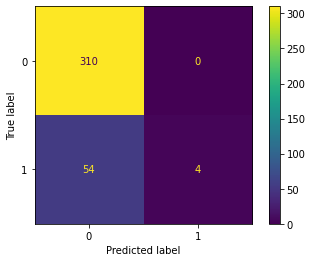

In [36]:
# 1로 예상하는 케이스가 저조 → predict_proba를 활용한 조절 필요
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)

In [37]:
# 참고 : RandomForest 수행
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=0, n_jobs=-1).fit(X_train, y_train)
rf_clf.score(X_test, y_test), roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])

(0.8532608695652174, 0.67119021134594)

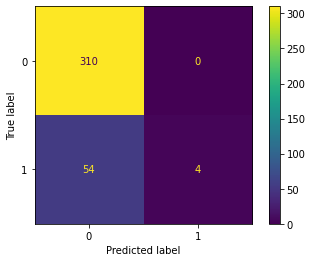

In [38]:
# 1로 예상하는 케이스가 저조 → predict_proba를 활용한 조절 필요
ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test)

In [39]:
# predict probability를 0.6을 기준으로
y_hat = np.where(logreg.predict_proba(X_test)[:, 0] >= 0.6, 0, 1)
y_hat

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

0.8478260869565217


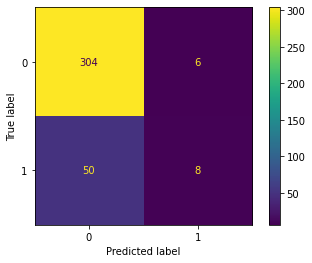

In [40]:
# prediction proba 0.6 기준 confusion matrix와 accuracy score 확인
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)
print(accuracy_score(y_test, y_hat))

In [41]:
# 참고 : RandomForest 기준 predict probability를 0.6을 기준으로
y_hat_rf = np.where(rf_clf.predict_proba(X_test)[:, 0] >= 0.6, 0, 1)
y_hat_rf

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

0.8532608695652174


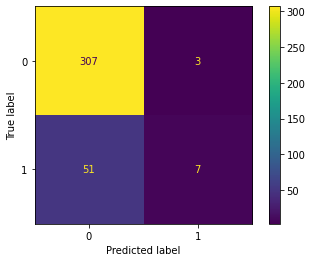

In [42]:
# 참고 : RandomForest 기준 prediction proba 0.6 기준 confusion matrix와 accuracy score 확인
# RandomForest가 좀 더 유의미
ConfusionMatrixDisplay.from_predictions(y_test, y_hat_rf)
print(accuracy_score(y_test, y_hat_rf))

In [43]:
# RandomForest 기준 feature importances 확인
df_feature_importances = pd.DataFrame(rf_clf.feature_importances_, index=X_fa.columns, columns=['Importance'])
df_feature_importances

,Importance
ManagingPosition,0.055346
HRPosition,0.068727
SalesPosition,0.060493
MoveFrequent,0.055716
CurrentWorkingYears,0.114706
Performance,0.062700
SOLevel,0.100101
ResearchPosition,0.043676
TravelFrequent,0.071272
EnvSatisfied,0.059637


In [29]:
# Logistic Regression의 coefficient 확인으로 Attrition에 positive 영향을 주는 요소 확인
# Travel Frequent가 가장 유의미하게 Attrition에 positive 영향. Sales 역시 Attrition의 경향성 존재
# 반대로 ManagingPosition 및 WorkExp 등이 negative 영향
pd.DataFrame(logreg.coef_.T, index=X_fa.columns, columns=['Coefficient'])

,Coefficient
ManagingPosition,-0.360855
WorkExp,0.091059
HRPosition,0.265815
SalesPosition,0.188052
Performance,-0.561301
Divorced_StockOption,-0.023535
MoveFrequent,-0.778199
HighJobLevel,0.314564
TravelFrequent,-0.104563
GenderFemale,-0.116698


In [47]:
# statsmodels.formula.api를 통한 모델 재확인 → significance 여부 등
# target값이 category 형식이면 에러 발생 → float or int로 수정해줘야
# 각 feature들의 p_value 확인으로 95% confidence level을 기준으로 유의하지 않은 feature들 확인
# no significance : HRPostion, Performance, EnvSatisfied, GenderFemale, MajorMarketing
data = pd.concat([X_train, y_train.astype('int')], axis=1)
formula = 'Attrition ~ ManagingPosition + HRPosition + SalesPosition + MoveFrequent + CurrentWorkingYears + Performance + SOLevel + ResearchPosition + TravelFrequent + EnvSatisfied + GenderFemale + MajorMedical + AgeWorkingYears + HighEducation + MajorMarkeing'
model = smfa.logit(formula, data=data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.395160
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 1102
Model:                          Logit   Df Residuals:                     1086
Method:                           MLE   Df Model:                           15
Date:                Wed, 26 Jul 2023   Pseudo R-squ.:                  0.1094
Time:                        21:52:02   Log-Likelihood:                -435.47
converged:                       True   LL-Null:                       -488.94
Covariance Type:            nonrobust   LLR p-value:                 6.220e-16
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.0271      0.126    -16.064      0.000      -2.274      -1.780
ManagingPosition       -0.3494      0.123     -2.839      0.005      -0.591      -0.108
HRPosition              0.0986      0.075      1.308      0.191      -0.049       0.246
SalesPosition           0.2611      0.090      2.899      0.004       0.085       0.438
MoveFrequent            0.1857      0.082      2.254      0.024       0.024       0.347
CurrentWorkingYears    -0.5629      0.109     -5.142      0.000      -0.777      -0.348
Performance            -0.0214      0.089     -0.241      0.810      -0.196       0.153
SOLevel                -0.2951      0.095     -3.111      0.002      -0.481      -0.109
ResearchPosition       -0.8175      0.300     -2.725      0.006      -1.405      -0.230
TravelFrequent          0.3127      0.078      4.027      0.000       0.161       0.465
EnvSatisfied           -0.1020      0.087     -1.177      0.239      -0.272       0.068
GenderFemale           -0.1258      0.089     -1.416      0.157      -0.300       0.048
MajorMedical           -0.2104      0.091     -2.303      0.021      -0.389      -0.031
AgeWorkingYears        -0.2900      0.094     -3.097      0.002      -0.473      -0.106
HighEducation          -0.1849      0.092     -2.008      0.045      -0.365      -0.004
MajorMarkeing           0.0159      0.082      0.194      0.846      -0.145       0.176
=======================================================================================
"""